In [2]:
!ls

sample_data  usageDirect-history.sqlite3


In [3]:
import sqlite3
import csv

In [4]:
def csvconverter(db_file, table_name, output_csv):

    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    cursor.execute(f"SELECT * FROM {table_name}")

    rows = cursor.fetchall()

    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = [col[1] for col in cursor.fetchall()]

    with open(output_csv, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        csv_writer.writerow(columns)

        csv_writer.writerows(rows)

    conn.close()
csvconverter("usageDirect-history.sqlite3","usageStats","output.csv")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


In [6]:
data = pd.read_csv('output.csv')

whatsapp_data = data[data['applicationId'] == 'org.polymorphicshade.newpipe']

whatsapp_data.to_csv('yt.csv', index=False)

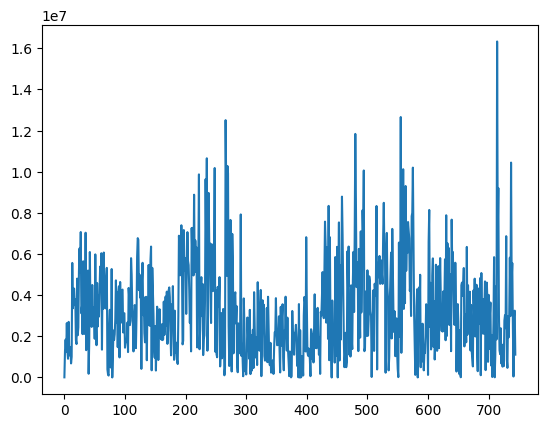

In [7]:
df = pd.read_csv('yt.csv')
timeseries = df[["timeUsed"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

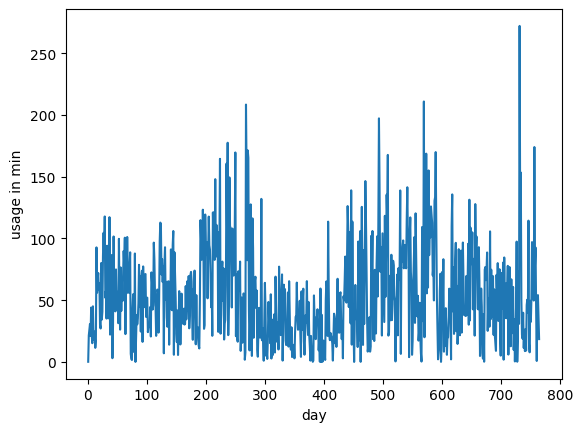

In [8]:
df = pd.read_csv('yt.csv')
df[["timeUsed"]] = df[["timeUsed"]]/60000
df[["day"]] = df[["day"]]-18951
usage = df[["timeUsed"]].values.astype('double')
date = df[["day"]].values.astype('int')
plt.plot(date,usage)
plt.xlabel("day")
plt.ylabel("usage in min")
plt.show()

In [9]:
train_size = int(len(usage) * 0.9)
test_size = len(usage) - train_size

train, test = timeseries[:train_size], timeseries[train_size:]

In [10]:
import torch
import numpy as np

In [14]:
def create_dataset(dataset,lookback):
    x=[]
    y=[]
    for i in range(len(dataset)-lookback):
      input = dataset[i:i+lookback]
      target = dataset[i+1:i+lookback+1]
      x.append(input)
      y.append(target)
    x = np.array(x)
    y= np.array(y)
    return torch.tensor(x),torch.tensor(y)


In [60]:
lookback = 30
xtrain,ytrain = create_dataset(train,lookback=lookback)
xtest,ytest = create_dataset(test,lookback)
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

torch.Size([640, 30, 1]) torch.Size([640, 30, 1])
torch.Size([45, 30, 1]) torch.Size([45, 30, 1])


In [61]:
import torch.nn as nn

class mlmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
    self.linear = nn.Linear(50, 1)
  def forward(self, x):
    x, _ = self.lstm(x)
    out = x[-1, :, :]
    x = self.linear(out)

    return x

In [62]:
import torch.optim as optim
import torch.utils.data as data

In [63]:
model = mlmodel()
optimizer = optim.Adam(model.parameters())
lossfn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(xtrain,ytrain),shuffle=True,batch_size =8)

In [64]:
epochs = 1000
for epoch in range(epochs):
  model.train()
  for xt,yt in loader:
    y_pred = model(xt)
    loss = lossfn(y_pred,ytrain)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if epoch%100 !=0:
    continue
  model.eval()
  with torch.no_grad():
    yt = model(xtrain)
    train_rmse = np.sqrt(lossfn(y_pred,ytrain))
    y_pred = model(xtest)
    test_rmse = np.sqrt(lossfn(y_pred,ytest))
  print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([640, 30, 1])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([45, 30, 1])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: train RMSE 4057802.2500, test RMSE 4187462.0000
Epoch 100: train RMSE 4057667.0000, test RMSE 4187342.2500
Epoch 200: train RMSE 4057532.2500, test RMSE 4187222.7500
Epoch 300: train RMSE 4057398.0000, test RMSE 4187103.7500
Epoch 400: train RMSE 4057263.5000, test RMSE 4186984.5000
Epoch 500: train RMSE 4057129.2500, test RMSE 4186865.7500
Epoch 600: train RMSE 4056994.7500, test RMSE 4186746.2500
Epoch 700: train RMSE 4056860.5000, test RMSE 4186627.2500
Epoch 800: train RMSE 4056726.0000, test RMSE 4186508.2500
Epoch 900: train RMSE 4056592.0000, test RMSE 4186389.2500
